**I/O device register**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Install required libraries**

In [24]:
!pip3 install transformers pandas nltk spacy classla

     |████████████████████████████████| 266kB 14.7MB/s 
  Created wheel for obeliks: filename=obeliks-1.0.4-cp37-none-any.whl size=14931 sha256=e5441acbc372cd5f0360bb22795b42e3e57ada75efb865d499154c76cef08239
  Stored in directory: /root/.cache/pip/wheels/da/42/8a/37d003a1d0613c2388b02bebc4b40c577320a1397e0ae9a7bc
Successfully built obeliks


In [25]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html 


Looking in links: https://download.pytorch.org/whl/torch_stable.html


# Random seed

In [52]:
import random
import numpy as np
import torch

seed_val = 2021

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# BERT 

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import pandas as pd
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import time
import datetime

In [5]:
def setup_classifier(
    model_name: str,
    num_labels: int) -> BertForSequenceClassification:

    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels = num_labels,
        output_attentions = False,
        output_hidden_states = False,
    )
    
    return model

In [6]:
def setup_data(
    model_name: str,
    x: pd.DataFrame, 
    y: pd.DataFrame,
    do_lower_case: bool,
    max_length: int) -> TensorDataset:

    tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case = do_lower_case)

    input_ids = []
    attention_masks = []

    for text in x:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = max_length,
            padding='max_length',
            return_attention_mask = True,
            return_tensors = 'pt',
            truncation = True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(y)

    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [9]:
def train_classifier(
    model: BertForSequenceClassification, 
    dataset: TensorDataset, 
    validation_ratio: float,
    batch_size: int,
    freeze_embeddings_layer: bool,
    freeze_encoder_layers: int,
    epochs: int) -> (BertForSequenceClassification, list):

    device = select_device()

    train_size = int(validation_ratio * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_dataloader = DataLoader(
        train_dataset,
        sampler = RandomSampler(train_dataset),
        batch_size = batch_size
    )

    validation_dataloader = DataLoader(
        val_dataset,
        sampler = SequentialSampler(val_dataset),
        batch_size = batch_size
    )

    modules = []

    if freeze_embeddings_layer:
        modules.append(model.bert.embeddings)
    
    for i in range(freeze_encoder_layers):
        modules.append(model.bert.encoder.layer[i])

    for module in modules:
        for param in module.parameters():
            param.requires_grad = False
    
    model.to(device)

    optimizer = AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr = 2e-5,
        eps = 1e-8
    )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = 0,
        num_training_steps = total_steps
    )

    training_stats = []

    total_t0 = time.time()

    for epoch_i in range(0, epochs):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()

        total_train_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):

            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        

            outputs = model(
                b_input_ids, 
                token_type_ids = None, 
                attention_mask = b_input_mask, 
                labels = b_labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_train_loss += loss.item()

            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
        

        print("")
        print("Running Validation...")

        t0 = time.time()

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in validation_dataloader:
            
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            with torch.no_grad():

                outputs = model(
                    b_input_ids, 
                    token_type_ids = None, 
                    attention_mask = b_input_mask,
                    labels = b_labels
                )
                
                loss = outputs.loss
                logits = outputs.logits
                
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    return model, training_stats

In [11]:
def test_classifier(
    model: BertForSequenceClassification, 
    dataset: TensorDataset,
    batch_size: int):

    device = select_device()

    prediction_dataloader = DataLoader(
        dataset, 
        sampler = SequentialSampler(dataset), 
        batch_size = batch_size
    )

    print("")
    print("Running Prediction...")

    model.to(device)

    model.eval()

    predictions , true_labels = [], []

    for batch in prediction_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2]
        
        with torch.no_grad():

            outputs = model(
                b_input_ids, 
                token_type_ids = None, 
                attention_mask = b_input_mask
            )

        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.numpy()
        
        #predictions.append(logits)
        #true_labels.append(label_ids)
        predictions.extend(list(np.argmax(logits, axis=1).flatten()))
        true_labels.extend(list(label_ids))
    
    print('DONE.')

    return predictions, true_labels


In [13]:
def save_checkpoint(path, model, optimizer, epoch, loss):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
        }, path)


def save_model(path, model):
    torch.save(model.state_dict(), path)


def load_checkpoint(path):
    checkpoint = torch.load(path)
    return checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['epoch'], checkpoint['loss']


def load_model(path):
    return torch.load(path)


def select_device():

    if torch.cuda.is_available():
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
        device = torch.device("cuda")
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    
    return device


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# Performance metrics

In [22]:
def avg_accuracy(predictions,labels):
    return sum(1 for i, j in zip(predictions, labels) if i == j) / len(predictions) 

def round_to_percentages(value):
    return round(round(value, 4) * 100, 2)

def majority_class(data):
    elements_count = {}
    for element in data:
        if element not in elements_count:
            elements_count[element] = 0
        elements_count[element] += 1
    maximum = max(elements_count, key=elements_count.get)
    return elements_count[maximum] / len(data)

def print_performance_metrics(predicted, true):
    matrix = {}
    labels = sorted(list(set(true)))

    for t in labels:
        for p in labels:
            matrix[(t, p)] = sum([1 for i, j in zip(true, predicted) if i == t and j == p]) / len(true)

    print()
    print("Confusion Matrix")
    print("Rows - Actual")
    print("Columns - Predicted")
    print()

    print(("{:>3}"+" | "+"{:>6}"*len(labels)+" | ").format(" ", *[p for p in labels]))

    print("-" * (3 + 3 + 6 * len(labels) + 3 + 6))

    for t in labels:
        print(("{:>3}"+" | "+"{:>6.2f}"*len(labels)+" | "+"{:>6.2f}").format(t, *[round_to_percentages(matrix[(t, p)]) for p in labels], round_to_percentages(sum([matrix[(t, p)] for p in labels]))))

    print("-" * (3 + 3 + 6 * len(labels) + 3 + 6))

    print(("{:>3}"+" | "+"{:>6.2f}"*len(labels)+" | ").format(" ", *[round_to_percentages(sum([matrix[(t, p)] for t in labels])) for p in labels]))
    
    print()
    print("{:<35}:{:>8.4f}".format("Majority Class", round(majority_class(true), 4)))
    print("{:<35}:{:>8.4f}".format("Accuracy", round(avg_accuracy(predicted, true), 4)))
    print()

    if len(labels) == 2:
        sensitivity = matrix[(labels[0], labels[0])] / (matrix[(labels[0], labels[0])] + matrix[(labels[0], labels[1])])
        specificity = matrix[(labels[1], labels[1])] / (matrix[(labels[1], labels[1])] + matrix[(labels[1], labels[0])])
        positive_predictive = matrix[(labels[0], labels[0])] / (matrix[(labels[0], labels[0])] + matrix[(labels[1], labels[0])])
        negative_predictive = matrix[(labels[1], labels[1])] / (matrix[(labels[1], labels[1])] + matrix[(labels[0], labels[1])])
        f1_score = 2 * ((positive_predictive * sensitivity) / (positive_predictive + sensitivity))

        print("{:<35}:{:>8.4f}".format("Sensitivity, Recall", round(sensitivity, 4)))
        print("{:<35}:{:>8.4f}".format("Specificity", round(specificity, 4)))
        print("{:<35}:{:>8.4f}".format("Positive Predictive, Precision", round(positive_predictive, 4)))
        print("{:<35}:{:>8.4f}".format("Negative Predictive", round(negative_predictive, 4)))
        print("{:<35}:{:>8.4f}".format("F1 Score", round(f1_score, 4)))

# Preprocessing

In [40]:
import spacy
import re
import classla

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

classla.download('sl')
classla.download('sl', type='nonstandard')

nlp_eng = spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner'])
eng_stopwords = set(nlp_eng.Defaults.stop_words)
slo_stopwords = set(stopwords.words('slovene'))

def eng_preprocessing(text, remove_stopwords=True, do_lemmatization=True):

    text = base_preprocessing(text)

    tokens = []

    # split text to single words
    words = word_tokenize(text)

    lemmer = WordNetLemmatizer()

    # remove stopwords and words with length 1
    for word in words:
        if not remove_stopwords or word not in eng_stopwords:
            if do_lemmatization:
                word = lemmer.lemmatize(word)
            tokens.append(word)

    # convert tokens back to text
    preprocessed_text = ' '.join([str(element) for element in tokens])
    return preprocessed_text

def slo_preprocessing(dataset, remove_stopwords=True, do_lemmatization=True):

    # do base proccesing
    dataset['preprocessed'] = dataset['Text'].apply(base_preprocessing)

    # create pipelines
    tokenizer = classla.Pipeline('sl', processors='tokenize', type='nonstandard', logging_level='WARN')
    lemmatizer = classla.Pipeline('sl', processors='tokenize, lemma', type='nonstandard', logging_level='WARN')

    # do tokenization
    documents = '\n'.join(dataset['preprocessed'].values)
    out_docs = tokenizer(documents)

    for i, sentence in enumerate(out_docs.sentences):
        #print("DOCUMENT")
        seq = []
        for word in sentence.words:
            if not remove_stopwords or word.text not in slo_stopwords:
                seq.append(word.text)

        dataset.at[i, 'preprocessed'] = ' '.join(seq)

    # do lemmatization
    if do_lemmatization:
        documents = '\n'.join(dataset['preprocessed'].values)
        out_docs = lemmatizer(documents)
        
        for i, sentence in enumerate(out_docs.sentences):
            dataset.at[i, 'preprocessed'] = ' '.join(word.lemma for word in sentence.words)

    return dataset

def base_preprocessing(text):

    EMOJI_PATTERN = re.compile(
        "(["
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "])"
    )
    text = re.sub(EMOJI_PATTERN,"",text)
    # remove (twitter) urls
    text = re.sub(r"http://t.co/[a-zA-Z0-9čČšŠžŽ]+", "", text)
    text = re.sub(r"https://t.co/[a-zA-Z0-9čČšŠžŽ]+", "", text)

    # remove all hashtags or @name Mentions (Usernames only allowed to includes characters A-Z, 0-9 and underscores)
    text = re.sub(r"[@#][a-zA-Z0-9_čČšŠžŽ]+", "", text)

    # remove non alphabetical characters
    text = re.sub(r"[^a-zA-Z0-9\sčČšŠžŽ]", "", text)

    # remove multiple white spaces
    text = re.sub(' +', ' ', text)

    # convert all letters to lower case
    text = text.lower()

    return text.strip()

def run_dataset_preparation(dataset, lang="eng", remove_stopwords=True, do_lemmatization=True):

    dataset = dataset.dropna(how='any', axis=0)
    if lang == "eng":
        dataset['preprocessed'] = dataset['Text'].apply(eng_preprocessing, remove_stopwords=remove_stopwords, do_lemmatization=do_lemmatization)
    elif lang == "slo":
        dataset = slo_preprocessing(dataset, remove_stopwords=remove_stopwords, do_lemmatization=do_lemmatization)

    x,y = dataset['preprocessed'], dataset['Label']
    data = (x,y)
    return data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


2021-04-22 17:51:56 INFO: Downloading these customized packages for language: sl (Slovenian)...
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |
| depparse  | standard |
| ner       | standard |
| pretrain  | standard |

2021-04-22 17:51:57 INFO: File exists: /root/classla_resources/sl/pos/standard.pt.
2021-04-22 17:51:57 INFO: File exists: /root/classla_resources/sl/lemma/standard.pt.
2021-04-22 17:51:57 INFO: File exists: /root/classla_resources/sl/depparse/standard.pt.
2021-04-22 17:51:57 INFO: File exists: /root/classla_resources/sl/ner/standard.pt.
2021-04-22 17:51:57 INFO: File exists: /root/classla_resources/sl/pretrain/standard.pt.
2021-04-22 17:51:58 INFO: Finished downloading models and saved to /root/classla_resources.
2021-04-22 17:51:58 INFO: Downloading these customized packages for language: sl (Slovenian)...
| Processor | Package     |
---------------------------
| tokenize  | nonstandard |
| po

# Other

In [62]:
import matplotlib.pyplot as plt

def distribution_dataset(data):
    class_distribution = {}
    for element in data:
        if element not in class_distribution:
            class_distribution[element] = 0
        class_distribution[element] += 1
    return class_distribution

# Binary Eng classification

## Setup

In [81]:
binary_data = pd.read_csv('drive/MyDrive/Data/Eng/Binary/data.csv')
x,y = run_dataset_preparation(binary_data, "eng", remove_stopwords=True, do_lemmatization=True)

In [82]:
model = setup_classifier(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    num_labels = 2
)

# model.load_state_dict(bert.load_model("models/m1.pt"))

dataset = setup_data(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    x = x,
    y = y,
    do_lower_case = False,
    max_length = 180
)

test_ratio = 0.8
train_size = int(test_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

Some weights of the model checkpoint at drive/MyDrive/classifiers/bert/CroSloEngual were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized fr

## Train dataset class distribution

{0: 34320, 1: 26243}


<BarContainer object of 2 artists>

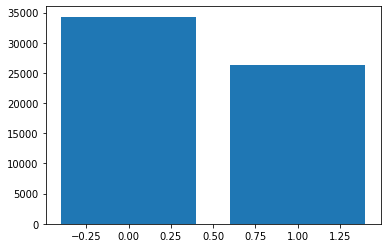

In [83]:
class_distribution = distribution_dataset([e[2].item() for e in list(train_dataset)])
print(class_distribution)
y = list(class_distribution.keys())
x = list(class_distribution.values())
plt.bar(y, x, color="tab:blue")

## Test dataset class distribution

{0: 8511, 1: 6630}


<BarContainer object of 2 artists>

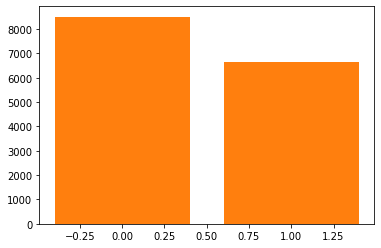

In [84]:
class_distribution = distribution_dataset([e[2].item() for e in list(test_dataset)])
print(class_distribution)
y = list(class_distribution.keys())
x = list(class_distribution.values())
plt.bar(y, x, color="tab:orange")

## Train

In [ ]:
model, stats = train_classifier(
    model = model,
    dataset = train_dataset,
    validation_ratio = 0.9,
    batch_size = 32,
    freeze_embeddings_layer = False,
    freeze_encoder_layers = 0,
    epochs = 1
)

## Test

In [42]:
predictions, true_labels = test_classifier(
    model = model,
    dataset = test_dataset,
    batch_size = 32
)

Some weights of the model checkpoint at drive/MyDrive/classifiers/bert/CroSloEngual were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized fr

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

======== Epoch 1 / 1 ========
Training...
  Batch    40  of  1,704.    Elapsed: 0:00:36.
  Batch    80  of  1,704.    Elapsed: 0:01:11.
  Batch   120  of  1,704.    Elapsed: 0:01:48.
  Batch   160  of  1,704.    Elapsed: 0:02:26.
  Batch   200  of  1,704.    Elapsed: 0:03:03.
  Batch   240  of  1,704.    Elapsed: 0:03:40.
  Batch   280  of  1,704.    Elapsed: 0:04:18.
  Batch   320  of  1,704.    Elapsed: 0:04:55.
  Batch   360  of  1,704.    Elapsed: 0:05:33.
  Batch   400  of  1,704.    Elapsed: 0:06:10.
  Batch   440  of  1,704.    Elapsed: 0:06:47.
  Batch   480  of  1,704.    Elapsed: 0:07:25.
  Batch   520  of  1,704.    Elapsed: 0:08:02.
  Batch   560  of  1,704.    Elapsed: 0:08:39.
  Batch   600  of  1,704.    Elapsed: 0:09:17.
  Batch   640  of  1,704.    Elapsed: 0:09:54.
  Batch   680  of  1,704.    Elapsed: 0:10:32.
  Batch   720  of  1,704.    Elapsed: 0:11:09.
  Batch   760  of  1,704.    Elapsed: 0:11:46.
  Ba

## Performance

In [48]:
print_performance_metrics(predictions, true_labels)


Confusion Matrix
Rows - Actual
Columns - Predicted

    |      0     1 | 
---------------------------
  0 |  53.52  3.63 |  57.15
  1 |   4.73 38.12 |  42.85
---------------------------
    |  58.25 41.75 | 

Majority Class                     :  0.5715
Accuracy                           :  0.9164

Sensitivity, Recall                :  0.9364
Specificity                        :  0.8896
Positive Predictive, Precision     :  0.9188
Negative Predictive                :  0.9130
F1 Score                           :  0.9275


**Saving model**

In [44]:
save_model("drive/MyDrive/models/binary.pt", model)

# Multiclass Eng classification

## Setup

In [109]:
multiclass_data = pd.read_csv('drive/MyDrive/Data/Eng/Multiclass/data.csv')
x,y = run_dataset_preparation(multiclass_data, "eng", remove_stopwords=True, do_lemmatization=True)

In [110]:
model = setup_classifier(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    num_labels = 6
)

# model.load_state_dict(bert.load_model("models/m1.pt"))

dataset = setup_data(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    x = x,
    y = y,
    do_lower_case = False,
    max_length = 180
)

test_ratio = 0.8
train_size = int(test_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

Some weights of the model checkpoint at drive/MyDrive/classifiers/bert/CroSloEngual were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized fr

## Train dataset class distribution

{0: 34261, 2: 5184, 4: 534, 3: 3009, 1: 1056, 5: 287}


<BarContainer object of 6 artists>

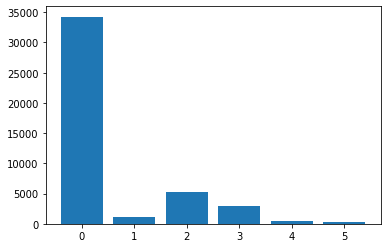

In [111]:
class_distribution = distribution_dataset([e[2].item() for e in list(train_dataset)])
print(class_distribution)
y = list(class_distribution.keys())
x = list(class_distribution.values())
plt.bar(y, x, color="tab:blue")

## Test dataset class distribution

{0: 8570, 5: 74, 2: 1263, 3: 782, 1: 275, 4: 119}


<BarContainer object of 6 artists>

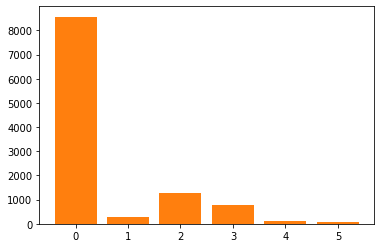

In [112]:
class_distribution = distribution_dataset([e[2].item() for e in list(test_dataset)])
print(class_distribution)
y = list(class_distribution.keys())
x = list(class_distribution.values())
plt.bar(y, x, color="tab:orange")

## Train

In [113]:
model, stats = train_classifier(
    model = model,
    dataset = train_dataset,
    validation_ratio = 0.9,
    batch_size = 32,
    freeze_embeddings_layer = False,
    freeze_encoder_layers = 0,
    epochs = 1
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

======== Epoch 1 / 1 ========
Training...
  Batch    40  of  1,247.    Elapsed: 0:00:37.
  Batch    80  of  1,247.    Elapsed: 0:01:15.
  Batch   120  of  1,247.    Elapsed: 0:01:52.
  Batch   160  of  1,247.    Elapsed: 0:02:30.
  Batch   200  of  1,247.    Elapsed: 0:03:07.
  Batch   240  of  1,247.    Elapsed: 0:03:44.
  Batch   280  of  1,247.    Elapsed: 0:04:22.
  Batch   320  of  1,247.    Elapsed: 0:04:59.
  Batch   360  of  1,247.    Elapsed: 0:05:36.
  Batch   400  of  1,247.    Elapsed: 0:06:14.
  Batch   440  of  1,247.    Elapsed: 0:06:51.
  Batch   480  of  1,247.    Elapsed: 0:07:28.
  Batch   520  of  1,247.    Elapsed: 0:08:05.
  Batch   560  of  1,247.    Elapsed: 0:08:43.
  Batch   600  of  1,247.    Elapsed: 0:09:20.
  Batch   640  of  1,247.    Elapsed: 0:09:57.
  Batch   680  of  1,247.    Elapsed: 0:10:35.
  Batch   720  of  1,247.    Elapsed: 0:11:12.
  Batch   760  of  1,247.    Elapsed: 0:11:49.
  Ba

## Test

In [114]:
predictions, true_labels = test_classifier(
    model = model,
    dataset = test_dataset,
    batch_size = 32
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

Running Prediction...
DONE.


## Performance

In [115]:
print_performance_metrics(predictions, true_labels)


Confusion Matrix
Rows - Actual
Columns - Predicted

    |      0     1     2     3     4     5 | 
---------------------------------------------------
  0 |  75.66  0.26  0.72  0.62  0.06  0.00 |  77.33
  1 |   0.32  2.00  0.05  0.09  0.01  0.02 |   2.48
  2 |   0.21  0.05 11.04  0.05  0.05  0.00 |  11.40
  3 |   0.20  0.24  0.02  6.57  0.00  0.03 |   7.06
  4 |   0.06  0.01  0.04  0.01  0.93  0.03 |   1.07
  5 |   0.17  0.05  0.01  0.23  0.02  0.20 |   0.67
---------------------------------------------------
    |  76.61  2.61 11.87  7.57  1.06  0.27 | 

Majority Class                     :  0.7733
Accuracy                           :  0.9640



**Saving model**

In [116]:
save_model("drive/MyDrive/models/multiclass.pt", model)

# Binary Slo classification

## Setup

In [100]:
binary_data = pd.read_csv('drive/MyDrive/Data/Slo/Binary/data.csv')
x,y = run_dataset_preparation(binary_data, "slo", remove_stopwords=True, do_lemmatization=True)

In [101]:
model = setup_classifier(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    num_labels = 2
)

model.load_state_dict(load_model("drive/MyDrive/models/binary.pt"))

dataset = setup_data(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    x = x,
    y = y,
    do_lower_case = False,
    max_length = 180
)

Some weights of the model checkpoint at drive/MyDrive/classifiers/bert/CroSloEngual were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized fr

## Dataset class distribution

{0: 1068, 1: 426}


<BarContainer object of 2 artists>

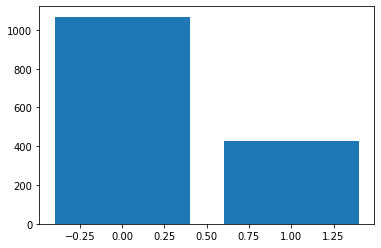

In [102]:
class_distribution = distribution_dataset([e[2].item() for e in list(dataset)])
print(class_distribution)
y = list(class_distribution.keys())
x = list(class_distribution.values())
plt.bar(y, x, color="tab:blue")

## Test

In [103]:
predictions, true_labels = test_classifier(
    model = model,
    dataset = dataset,
    batch_size = 32
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

Running Prediction...
DONE.


## Performance

In [104]:
print_performance_metrics(predictions, true_labels)


Confusion Matrix
Rows - Actual
Columns - Predicted

    |      0     1 | 
---------------------------
  0 |  70.35  1.14 |  71.49
  1 |  27.71  0.80 |  28.51
---------------------------
    |  98.06  1.94 | 

Majority Class                     :  0.7149
Accuracy                           :  0.7115

Sensitivity, Recall                :  0.9841
Specificity                        :  0.0282
Positive Predictive, Precision     :  0.7174
Negative Predictive                :  0.4138
F1 Score                           :  0.8298


# Multiclass Slo classification

## Setup

In [117]:
multiclass_data = pd.read_csv('drive/MyDrive/Data/Slo/Multiclass/data.csv')
x,y = run_dataset_preparation(multiclass_data, "slo", remove_stopwords=True, do_lemmatization=True)

In [118]:
model = setup_classifier(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    num_labels = 6
)

model.load_state_dict(load_model("drive/MyDrive/models/multiclass.pt"))

dataset = setup_data(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    x = x,
    y = y,
    do_lower_case = False,
    max_length = 180
)

Some weights of the model checkpoint at drive/MyDrive/classifiers/bert/CroSloEngual were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized fr

## Dataset class distribution

{0: 1068, 5: 357, 4: 8, 1: 26, 2: 20, 3: 23}


<BarContainer object of 6 artists>

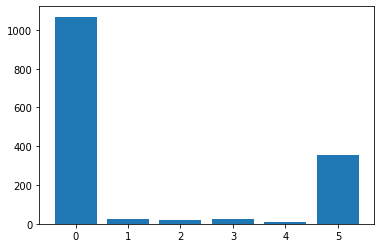

In [119]:
class_distribution = distribution_dataset([e[2].item() for e in list(dataset)])
print(class_distribution)
y = list(class_distribution.keys())
x = list(class_distribution.values())
plt.bar(y, x, color="tab:blue")

## Test

In [120]:
predictions, true_labels = test_classifier(
    model = model,
    dataset = dataset,
    batch_size = 32
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

Running Prediction...
DONE.


## Performance

In [121]:
print_performance_metrics(predictions, true_labels)


Confusion Matrix
Rows - Actual
Columns - Predicted

    |      0     1     2     3     4     5 | 
---------------------------------------------------
  0 |  70.84  0.13  0.07  0.07  0.00  0.00 |  71.11
  1 |   1.73  0.00  0.00  0.00  0.00  0.00 |   1.73
  2 |   1.33  0.00  0.00  0.00  0.00  0.00 |   1.33
  3 |   1.53  0.00  0.00  0.00  0.00  0.00 |   1.53
  4 |   0.53  0.00  0.00  0.00  0.00  0.00 |   0.53
  5 |  23.77  0.00  0.00  0.00  0.00  0.00 |  23.77
---------------------------------------------------
    |  99.73  0.13  0.07  0.07  0.00  0.00 | 

Majority Class                     :  0.7111
Accuracy                           :  0.7084

